In [1]:
!hostname

psanagpu111


In [2]:
import sys
ROOT_DIR = ".."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

sys.path.append("/reg/neh/home/iris/lcls2/psana")

In [3]:
import os
import time
import numpy as np
import six
import itertools
import h5py as h5
from mpi4py import MPI # module required to use MPI
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pysingfel as ps
import pysingfel.gpu as pg

import pysingfel as ps
import pysingfel.gpu as pg
from pysingfel.util import asnumpy, xp

In [4]:
beam = ps.Beam(ROOT_DIR+'/input/beam/amo86615.beam')

In [5]:
det = ps.Epix10kDetector(geom=ROOT_DIR+'/input/lcls/epix10ka2m/calib/Epix10ka2M::CalibV1/NoDetector.0:Epix10ka2M.0/geometry/0-end.data',beam=beam)

In [6]:
det.distance *= 1

In [7]:
particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/input/pdb/2CEX.pdb', ff='WK')

Unknown element or wrong line: 
 HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  

Unknown element or wrong line: 
 HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  

Unknown element or wrong line: 
 HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  

Unknown element or wrong line: 
 HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  

Unknown element or wrong line: 
 HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  

Unknown element or wrong line: 
 HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  



In [8]:
def demo(experiment):
    """Plot a few slices of the experiment."""
    Nrows = 1  # <- Modify this constant to have more/less images.
    plt.figure(figsize=(20, 4.5*Nrows-0.5))
    start = time.clock()
    for i in range(4*Nrows):
        plt.subplot(Nrows, 4, i+1)
        img = experiment.generate_image()
        plt.imshow(img, norm=LogNorm())
        plt.colorbar()
    stop = time.clock()
    plt.show()
    rate = 4 * Nrows / (stop - start)
    print("Image rate = {:.5f} images per second.".format(rate))

In [9]:
def demo1(experiment):
    img = experiment.generate_image()
    plt.imshow(img, norm=LogNorm())
    plt.colorbar()
    plt.savefig('SPI_epix10ka2m_1.png')
    plt.show()

In [10]:
experiment = ps.SPIExperiment(det, beam, particle)

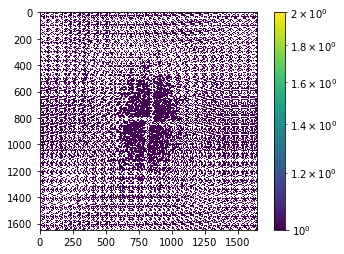

In [11]:
demo1(experiment)

/reg/neh/home/iris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/reg/neh/home/iris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


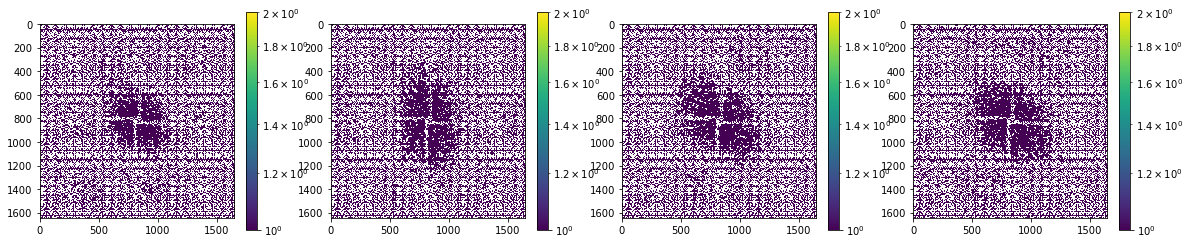

Image rate = 0.14114 images per second.


In [12]:
demo(experiment)

In [13]:
recidet = ps.ReciprocalDetector(det, beam)

In [14]:
exp = ps.Experiment(det, beam, [])

In [15]:
viz = ps.Visualizer(exp)

In [16]:
# Create mesh
mesh_length = 31
mesh, voxel_length = recidet.get_reciprocal_mesh(voxel_number_1d=mesh_length)

In [17]:
# Create volume
volume = pg.calculate_diffraction_pattern_gpu(mesh, particle, return_type='intensity')

In [18]:
# Center
center = det.geometry.point_coord_indexes((0, 0))
print(center)

(823, 823)


In [19]:
wave_vector = beam.get_wavevector()
wave_vector_norm = np.linalg.norm(wave_vector)
wave_vector_direction = wave_vector / wave_vector_norm

In [20]:
# Radius, backward
#q = np.linalg.norm(pixel_position_reciprocal)
q = 5e9
k = wave_vector_norm
s = q/(2*k)
d = det.distance
r = d * 2 * s * np.sqrt(1-s**2) / (1-2*s**2)
print(r)

0.2182695291413693


In [21]:
# Radius, forward
y = r

pixel_center = np.array([[0, y, det.distance]])
pixel_center_norm = np.linalg.norm(pixel_center, axis=1)
pixel_center_direction = pixel_center / pixel_center_norm[:, np.newaxis]

pixel_position_reciprocal = wave_vector_norm * (pixel_center_direction - wave_vector_direction)
print(pixel_position_reciprocal)

nq = np.linalg.norm(pixel_position_reciprocal)
print(nq)

[[ 0.00000000e+00  4.97116424e+09 -5.36214616e+08]]
5000000000.0


In [22]:
assert np.isclose(nq, q)

In [23]:
#pix_rad = det.geometry.point_coord_indexes((0, r*1e6))[1] - center[1]
pix_rad = r / np.median(det.pixel_width)
print(pix_rad)

2182.695291413693


In [24]:
from matplotlib.patches import Circle

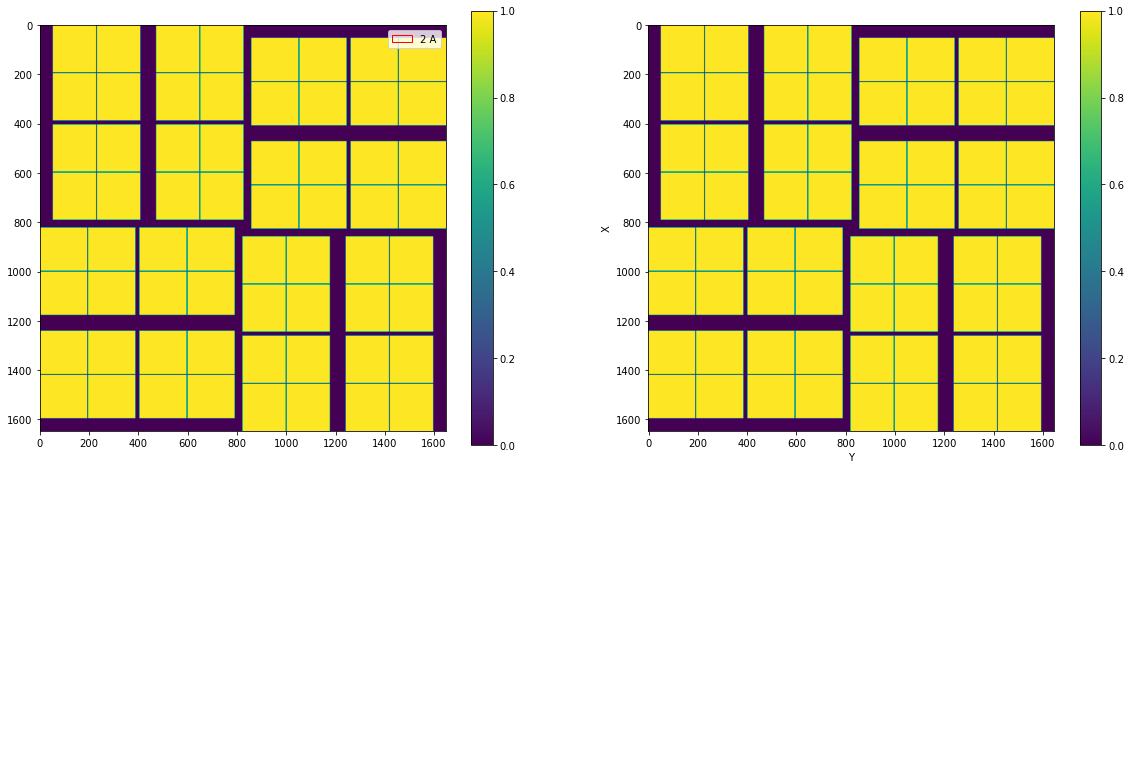

In [25]:
mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
label = '{:.2g} A'.format((q*1e-10)**-1)
ncenter = center[::-1]  # Swap x & y to match coordinate system
plt.gca().add_patch(Circle(ncenter, pix_rad, edgecolor='red', fill=False, label=label))
plt.legend()
plt.colorbar()

plt.subplot(1, 2, 2)
viz.imshow(img)
viz.add_diffraction_ring(q)
plt.show()

In [26]:
def add_circle(det, beam, q=None, res=None):
    """Add a circle on assembled image.
    
    Takes a detector, a beam, and a reciprocal distance (m-1).
    Call after plt.imshow but before plt.legend.
    """
    is_res = False
    if q is None:
        if res is None:
            raise TypeError("Please give q or res.")
        q = 1/res
        is_res = True
    elif res is not None:
        raise TypeError("Please give one of q or res.")
    
    # Center
    old_stdout = sys.stdout
    f = six.StringIO()
    center = det.geometry.point_coord_indexes((0, 0))
    sys.stdout = old_stdout
    
    # Radius
    k = np.linalg.norm(beam.get_wavevector())
    s = q/(2*k)
    d = det.distance
    r = d * 2 * s * np.sqrt(1-s**2) / (1-2*s**2)
    pix_rad = r / np.median(det.pixel_width)

    label = '{:.2g} A'.format((1/q)*1e+10)
    ncenter = center[::-1]  # Swap x & y to match coordinate system
    plt.gca().add_patch(Circle(ncenter, pix_rad, edgecolor='red', fill=False, label=label))

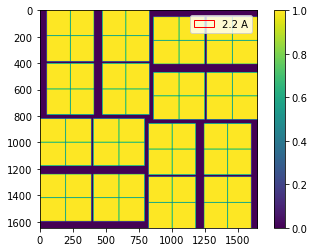

In [27]:
mask = recidet.pixel_distance_reciprocal < 0.9*q
img = det.assemble_image_stack(mask)

plt.imshow(img)
add_circle(det, beam, q=0.9*q)
plt.legend()
plt.colorbar()
plt.show()

In [28]:
def add_circles_10_A(det, beam):
    q_max = np.max(recidet.pixel_distance_reciprocal)
    res_max = q_max**-1
    res_10 = 10**(np.floor(np.log10(res_max)))
    n = 5
    cycle = (1, 2, 3, 4, 6)
    for i in itertools.cycle(cycle):
        if res_max < i*res_10:
            add_circle(det, beam, res=i*res_10)
            n -= 1
        if n <= 0:
            break
        if i == cycle[-1]:
            res_10 *= 10

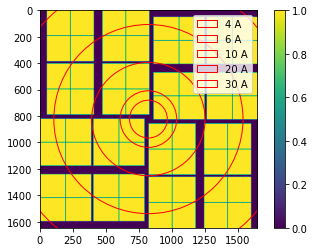

In [29]:
mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.imshow(img)
add_circles_10_A(det, beam)
plt.legend()
plt.colorbar()
plt.show()

In [30]:
def add_circle_round_middle(det, beam):
    q_max = np.max(recidet.pixel_distance_reciprocal) * 0.6
    q_10 = 10**(np.floor(np.log10(q_max)))
    for i in itertools.cycle(range(9, 0, -1)):
        if q_max > i * q_10:
            break
    add_circle(det, beam, q=i*q_10)

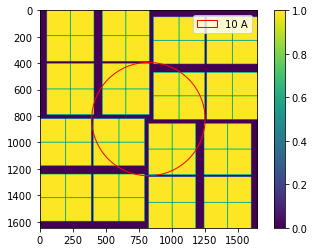

In [31]:
mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.imshow(img)
add_circle_round_middle(det, beam)
plt.legend()
plt.colorbar()
plt.show()

In [32]:
def add_circles_edge_A(det, beam):
    q_max = np.max(recidet.pixel_distance_reciprocal)
    q_start = q_max / 1.5
    for i in (1, 2, 3, 4, 5):
        add_circle(det, beam, q=i/5. * q_start)

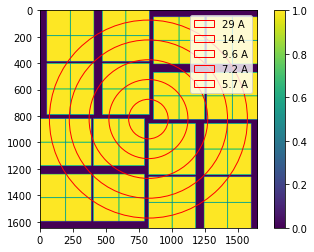

In [33]:
mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.imshow(img)
add_circles_edge_A(det, beam)
plt.legend()
plt.colorbar()
plt.show()

In [34]:
def add_circle(det, beam, q=None, res=None):
    """Add a circle on assembled image.
    
    Takes a detector, a beam, and a reciprocal distance (m-1).
    Call after plt.imshow but before plt.legend.
    """
    is_res = False
    if q is None:
        if res is None:
            raise TypeError("Please give q or res.")
        q = 1/res
        is_res = True
    elif res is not None:
        raise TypeError("Please give one of q or res.")
    
    # Center
    old_stdout = sys.stdout
    f = six.StringIO()
    center = det.geometry.point_coord_indexes((0, 0))
    sys.stdout = old_stdout
    
    # Radius
    k = np.linalg.norm(beam.get_wavevector())
    s = q/(2*k)
    d = det.distance
    r = d * 2 * s * np.sqrt(1-s**2) / (1-2*s**2)
    pix_rad = r / np.median(det.pixel_width)

    label = '{:.2g} A'.format((1/q)*1e+10)
    ncenter = center[::-1]  # Swap x & y to match coordinate system
    plt.gca().add_patch(Circle(ncenter, pix_rad, edgecolor='red', fill=False))
    plt.gca().annotate(label, xy=(ncenter[0], ncenter[1]+pix_rad), ha="center", va="bottom", color="red")

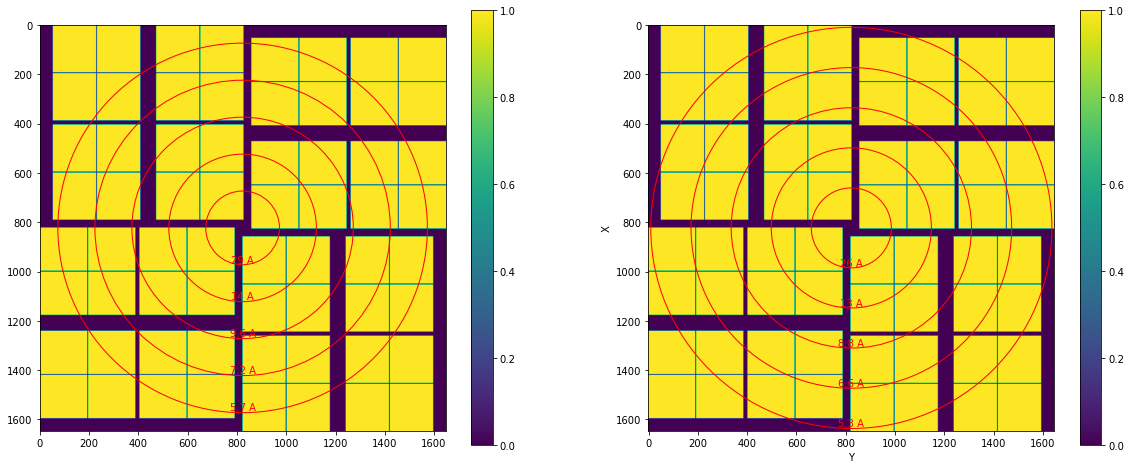

In [35]:
mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
add_circles_edge_A(det, beam)
plt.colorbar()

plt.subplot(1, 2, 2)
viz.imshow(img)
viz.add_diffraction_rings()
plt.show()

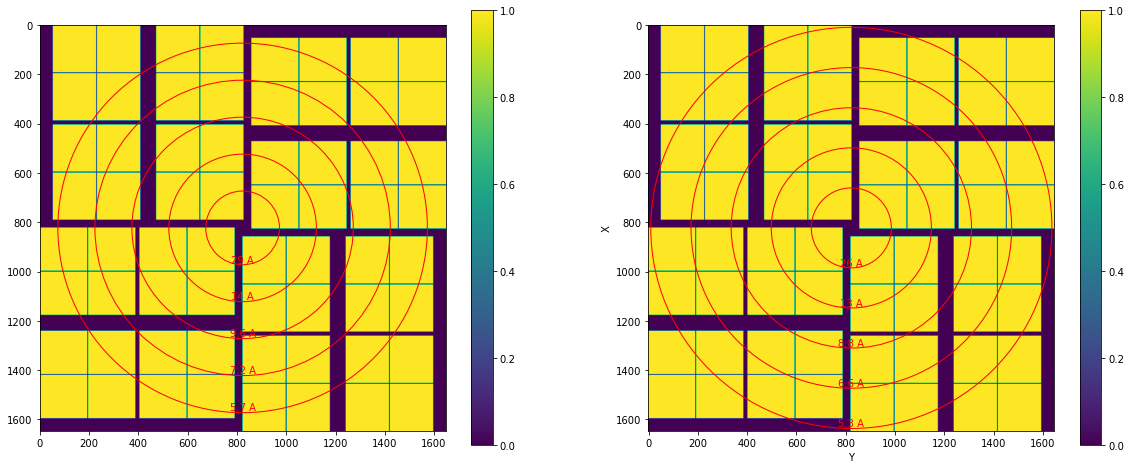

In [36]:
new_viz = ps.Visualizer(exp, diffraction_rings="auto")

mask = recidet.pixel_distance_reciprocal < q
img = det.assemble_image_stack(mask)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img)
add_circles_edge_A(det, beam)
plt.colorbar()

plt.subplot(1, 2, 2)
new_viz.imshow(img)
plt.show()

In [37]:
def demo(experiment):
    """Plot a few slices of the experiment."""
    Nrows = 1  # <- Modify this constant to have more/less images.
    plt.figure(figsize=(20, 4.5*Nrows-0.5))
    start = time.clock()
    for i in range(4*Nrows):
        plt.subplot(Nrows, 4, i+1)
        img = experiment.generate_image()
        plt.imshow(img, norm=LogNorm())
        add_circles_edge_A(det, beam)
        plt.colorbar()
    stop = time.clock()
    plt.show()
    rate = 4 * Nrows / (stop - start)
    print("Image rate = {:.5f} images per second.".format(rate))

/reg/neh/home/iris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """
/reg/neh/home/iris/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


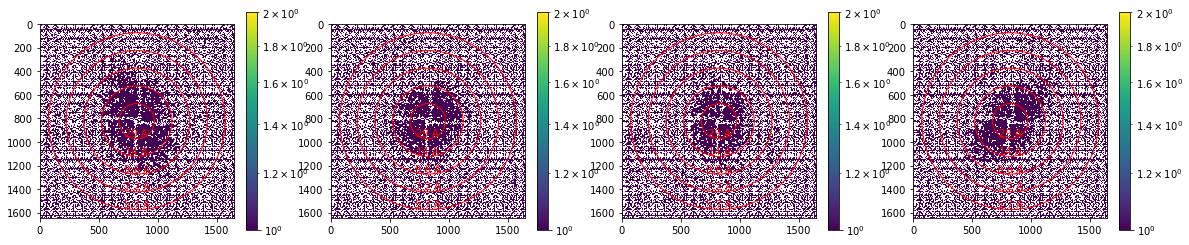

Image rate = 0.12473 images per second.


In [38]:
demo(experiment)